In [1]:
%pip install qiskit
%pip install pylatexenc
%pip install qiskit_aer
%pip install qiskit_ibm_runtime


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import matplotlib
import qiskit_aer
import pylatexenc
import random
import qiskit
from scipy.optimize import minimize

from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Implementing and benchmarking the 3-qubit surface code

## My best estimate for the pseudocode/components we'll need

#### Create a single logical qubit
      

*   Define a lattice of physical qubits (4x4?)
*   Define the stabilizer generators (vertex and plaquette stabilizers)
*   We're gonna do a rotated surface code -- this is state of the art


#### Replicate the logical qubit twice




#### Figure out how to implement interactions between the qubits



There's several alternate schemes depending on how you construct the lattice and if you want it to encode two logical qubits or one. https://arxiv.org/pdf/quant-ph/9811052 I mainly followed along with paper for two logical qubits and how they implemented the stabilizer circuits.

In [3]:
class DisjointSet:
  def __init__(self, vx_count):
    self.parent = dict((x,x) for x in vx_count)
    self.paths = {}
    for i in vx_count:
       self.paths[i]=[]


    self.rank = dict((x,0) for x in vx_count)

  def find(self, i):
    if self.parent[i] != i:
      self.parent[i] = self.find(self.parent[i])
    return self.parent[i]

  def union(self, x, y, e):
    s1 = self.find(x)
    s2 = self.find(y)
    #print("Run with "+str(x)+" "+str(y))
    #print(self.rank)
    if s1 != s2:

      if self.rank[s1] < self.rank[s2]:
          self.parent[s1] = s2
          self.rank[s2] += 1 + self.rank[s1]
          self.paths[s1].append(e)
          self.paths[s2] += self.paths[s1]

      else:
          self.parent[s2] = s1
          self.rank[s1] += 1 + self.rank[s2]
          self.paths[s2].append(e)
          self.paths[s1] += self.paths[s2]
   
  def get_highest_rank_tree(self):
    max_rank = -1
    max_rank_index = 0
    
    for i in self.rank.keys():
      if self.rank[i] > max_rank:
        max_rank = self.rank[i]
        max_rank_index = i
    return self.paths[max_rank_index]


In [4]:
class Graph:
  def __init__(self):
    self.vertexes = []
    self.edges = []
    self.minimum_spanning_tree = None
  def add_vertex(self, v):
    self.vertexes.append(v)
  def get_edge_other_vertex(self, v, edge):
    #print("Called vertex "+str(v)+" and edge "+str(edge))
    if v == edge["v1"]: return edge["v2"]
    else: return edge["v1"]

  def add_edge(self, v1, v2, w, path):
    self.edges.append({"v1":v1, "v2":v2, "weight":w, "data_qubit_path": path})

  def sort_fun(self, edge):
    return edge["weight"]

  def get_minimum_spanning_tree(self):

    #Sort edges so we go through them highest to lowest order of weight
    self.edges.sort(key=self.sort_fun)
    tree_tracker = DisjointSet(self.vertexes)
    count = 0

    for e in self.edges:
      if tree_tracker.find(e["v1"]) != tree_tracker.find(e["v2"]):
        tree_tracker.union(e["v1"], e["v2"], e)
        count += 1
        if count == len(self.vertexes)-1:
          break

    #We've obtained a minimum spanning tree
    min_span = tree_tracker.get_highest_rank_tree()

    #Disconnect the middle edges to get a set of disconnected edges
    min_span.sort(key=self.sort_fun)

    count_edges_vertex_in = dict((x,0) for x in self.vertexes)
    vertex_to_edges = dict((x,[]) for x in self.vertexes)

    for e in min_span:
      count_edges_vertex_in[e["v1"]] += 1
      count_edges_vertex_in[e["v2"]] += 1
      vertex_to_edges[e["v1"]].append(e)
      vertex_to_edges[e["v2"]].append(e)

   
    #only_one = list(x for x in self.vertexes if count_edges_vertex_in[x]==1)
    count_edges_vertex_in = dict(sorted(filter(lambda item: item[1], count_edges_vertex_in.items()), key=lambda item: item[1]))
    
    vertex_used = []
    shortest_edges = []

   
    #print(vertex_to_edges)
    for v in count_edges_vertex_in:
      for e in vertex_to_edges[v]:
        if self.get_edge_other_vertex(v,e) not in vertex_used:
          vertex_used.append(v)
          vertex_used.append(self.get_edge_other_vertex(v,e))
          shortest_edges.append(e)
        

      if len(vertex_used) == len(self.vertexes):
        break


    return shortest_edges





In [5]:
class Tree:
  def __init__(self, root):
    self.root = Node(None, root)
    #self.nodes = {root: self.root}

  def add_to_path(self, parent, node):
   
    nodes_list = []
    if isinstance(node, list):
      for n in node:
        new_node = Node(parent, n)
        parent.add_child(new_node)
        nodes_list.append(new_node)
    else:
      new_node = Node(parent, node)
      nodes_list.append(new_node)
      parent.add_child(self.nodes[node])
    return nodes_list

  def get_path_to_root(self, node):
    #print("Node "+str(node))
    #print("Root "+str(self.root.name))
    
    path = []
    distance = 0
  
    while node != None:
      #print(node.name)
      path = path + [node.name]
      distance = distance + 1
      node = node.parent
      
    #print(" ")
    return path, distance-1




In [6]:
class Node:
    def __init__(self, parent, name):
      self.parent = parent
      self.name = name
      self.children = []

    def add_child(self, c):
      self.children.append(c)

    def add_children(self, c):
      self.children = self.children + c


In [7]:
#TODO: Add Description
class SurfaceCode:

  def __init__(self, d, T):
    '''
    Distance d surface code for T rounds of error correction (syndrome measurement)
    * A surface code of distance d needs 2*d**2 physical qubits to support it the encodes the logical qubit value
    *
    '''
    self.d = d
    self.T = 0
    #TODO: Edit to give correct (2d-1)^2
    # SHREYA THOUGHTS: no this is not true -- d is the distance of the code = distance to the next valid state (qubit configuration). a code can correct floor((d-1)/2) errors
    # TODO: what is n? number of physical qubits in the lattice? afaik that is (2d-1)^2 for an unrotated surface code. for toric code we have [n,k,d] = [(2d)^2, 2, d]
    # for example we are implementing a [25, 1, 3] surface code if we're going for unrotated (this is the smallest one possible), so n = (6-1)^2 = 25
    self.n = d - 1
    self.first_round = True
    #qubits
    self.data_qubits = QuantumRegister(2*(self.n*self.n), "data_qubits")
    self.x_stabilizer_qubits = QuantumRegister(self.n*self.n, "x_stabilizer_qubits")
    self.z_stabilizer_qubits = QuantumRegister(self.n*self.n, "z_stabilizer_qubits")
    #classical
    self.classical_data_bits = ClassicalRegister(2*(self.n*self.n), "classical_data_bits")
    self.x_syndrome_bits = ClassicalRegister((self.n*self.n), "x_syndrome")
    self.z_syndrome_bits = ClassicalRegister((self.n*self.n), "z_syndrome")
    self.x_old_syndrome = [0] * self.n * self.n
    self.z_old_syndrome = [0] * self.n * self.n
    self.circuit = QuantumCircuit(self.data_qubits, self.x_stabilizer_qubits, self.z_stabilizer_qubits, self.classical_data_bits, self.x_syndrome_bits, self.z_syndrome_bits)
    self.registers = {"data_qubits", "x_stabilizer_qubits","z_stabilizer_qubits","classical_data_bits", "x_syndrome_bits", "z_syndrome_bits"}


    self.lattice = self.construct_lattice(self.n)
    self.x_pauli_frame = [1]*self.n*(self.n*2)
    self.z_pauli_frame = [1]*self.n*(self.n*2)
    self.x_generators = self.create_x_generators(self.lattice,self.n)
    self.z_generators = self.create_z_generators(self.lattice,self.n)
   
    self.x_logic_1 = []
    self.x_logic_2 = []
    self.z_logic_1 = []
    self.z_logic_2 = []
    for j in range(0,self.n):
        
        #TODO Add some prep for quantum state so can give logic in + - states
        self.x_logic_1.append((1,j))
        self.x_logic_2.append((j*2,1))
        self.z_logic_2.append((2,j))
        self.z_logic_1.append((j*2+1,1))
  def reset(self):
    first_round = True
    self.circuit = QuantumCircuit(self.data_qubits, self.x_stabilizer_qubits, self.z_stabilizer_qubits, self.classical_data_bits, self.x_syndrome_bits, self.z_syndrome_bits)
  def initalize_state(self,basis, bit1,bit2):
    #TODO implement for x basis as well
    
      if basis == "x":
        self.circuit.h(self.data_qubits)
        if bit1 == 1:
          for c in self.z_logic_1:
            self.circuit.z(self.data_qubits[c[0]*self.n+c[1]])
        if bit2 == 1:
          for c in self.z_logic_2:
            self.circuit.z(self.data_qubits[c[0]*self.n+c[1]])
      else:
        if bit1 == 1:
          for c in self.x_logic_1:
            self.circuit.x(self.data_qubits[c[0]*self.n+c[1]])
        if bit2 == 1:
          for c in self.x_logic_2:
            self.circuit.z(self.data_qubits[c[0]*self.n+c[1]])

  def construct_lattice(self, n):
    """Constructs a lattice out of qubit indexes.
    Each qubit is an edge - 2-D array where first row is first horionztal qubit row, second is first vertical qubit row"""
    edges = []#np.array()
    horizontal_edges = []
    vertical_edges = []
    for e in range(0,2*n):
      #Horizontal if even, verical if odd
      start = n*e
      row = [*range(start,start+n)]
      edges.append(row)

      '''if e%2 == 0:
          horizontal_edges.append(row)
      else:
        vertical_edges.append(row)'''

    return edges

  def create_x_generators(self, lattice, n):
    '''Creates list of x genarator. X generator is a list of data qubit indexes the generator impacts.'''
    x_gen = []

    for i in range(0,n):
      for j in range(0,n):
        upper_edge = 2*i-1 if 2*i-1 > 0 else 2*n-1

        x_gen.append([lattice[upper_edge][(j+1)%n],lattice[2*i][j],lattice[2*i][(j+1)%n],lattice[2*i+1][(j+1)%n]])

    return x_gen

  def create_z_generators(self, lattice, n):
    
    '''Creates list of z genarator. Z generator is a list of data qubit indexes the generator impacts.'''
    z_gen = []
    for i in range(0,n):
      for j in range(0,n):
        right_edge = (j+1)%n
        z_gen.append([lattice[2*i][j]
                      ,lattice[2*i+1][right_edge]
                      ,lattice[2*i+1][j]
                      ,lattice[(2*i+2)%(2*n)][j]])
    return z_gen
  '''def encode_physical_qubits(self, logical_qubit):
    #Logical qubit Encoding
    #TODO: Encode even parity for 0, odd for 1
    #Create superposition of all possible states where rules are followed - I think this
    #TODO Got lost in the variable sauce and wasn't sure the exact translation into a circuit
    self.circuit'''

  def add_x_stabilizer_measurement(self, stabilizer_index, stabilizer):
    '''Add a specified stabilizer to the surface circuit'''
    self.circuit.h(self.x_stabilizer_qubits[stabilizer_index])
    for q in stabilizer:
      self.circuit.cx(self.x_stabilizer_qubits[stabilizer_index], self.data_qubits[q])

    self.circuit.h(self.x_stabilizer_qubits[stabilizer_index])
    #self.circuit.measure(self.x_stabilizer_qubits[stabilizer_index], self.x_syndrome_bits[stabilizer_index])
    self.circuit.barrier()

  def add_z_stabilizer_measurement(self, stabilizer_index, stabilizer):
    for q in stabilizer:
      self.circuit.cx(self.data_qubits[q],self.z_stabilizer_qubits[stabilizer_index])

    #self.circuit.measure(self.z_stabilizer_qubits[stabilizer_index], self.z_syndrome_bits[stabilizer_index])
    self.circuit.barrier()
  def reset_circuit(self):
    n = self.d - 1

    #self.x_stabilizer_qubits = QuantumRegister(n*n, "x_stabilizer_qubits")
    #self.z_stabilizer_qubits = QuantumRegister(n*n, "z_stabilizer_qubits")
    #self.classical_data_bits = ClassicalRegister(2*(n*n), "classical_data_bits")
    #self.x_syndrome_bits = ClassicalRegister((n*n), "x_syndrome")
    #self.z_syndrome_bits = ClassicalRegister((n*n), "z_syndrome")
    #self.x_old_syndrome_bits = ClassicalRegister((n*n), "x_old_syndrome")
    #self.z_old_syndrome_bits = ClassicalRegister((n*n), "z_old_syndrome")

    self.circuit = QuantumCircuit(self.data_qubits, self.x_stabilizer_qubits, self.z_stabilizer_qubits, self.classical_data_bits, self.x_syndrome_bits, self.z_syndrome_bits)
    #self.registers = {"data_qubits", "x_stabilizer_qubits","z_stabilizer_qubits","classical_data_bits", "x_syndrome", "z_syndrome"}
  def add_cycle_stabilizers(self):
    "Cycles through stabilizers and updates syndrome qubit measurements. Returns list of x syndrome flags and z syndrome flag and a boolean saying if any flags have happened."
    #add stabilizer
    self.circuit.h(self.x_stabilizer_qubits)
    for j in range(0,4):
      for i in range(0,self.n*self.n):
        self.circuit.cx(self.data_qubits[self.z_generators[i][j]],self.z_stabilizer_qubits[i])
      for i in range(0,self.n*self.n):
        self.circuit.cx(self.x_stabilizer_qubits[i], self.data_qubits[self.x_generators[i][j]])
      self.circuit.barrier()
    
    self.circuit.h(self.x_stabilizer_qubits)
    self.circuit.barrier()
    self.circuit.measure(self.z_stabilizer_qubits, self.z_syndrome_bits)
    self.circuit.reset(self.z_stabilizer_qubits)
    self.circuit.barrier()
    self.circuit.measure(self.x_stabilizer_qubits, self.x_syndrome_bits)
    self.circuit.reset(self.z_stabilizer_qubits)
    if self.first_round:
      result = AerSimulator().run(self.circuit).result()
      stats = result.get_counts()
      #print(len(stats))
      max = 0
      for s in stats:
        if max<stats[s]:
          max = stats[s]
          syn_string = s

      print("First syndrome " + syn_string)
      #print(result)
      syn = syn_string.split()
      #TODO Check ordering first
     
      print("Syndrome X" +str(list(map(int, list(syn[1])))))
      print("Syndrome Z" +str(list(map(int, list(syn[0])))))
      self.x_old_syndrome = list(map(int, list(syn[1])))
      self.z_old_syndrome = list(map(int, list(syn[0])))
      print("Old Syndrome X" +str(self.x_old_syndrome))
      print("Old Syndrome Z" +str(self.z_old_syndrome))
      self.first_round = False
      

  def error_detection(self, backend, pm, simulator = True):
    "Run circuit and flags syndrome bits based expected parity."
    error_exists = False
    x_flags = [0]*self.n*self.n
    z_flags = [0]*self.n*self.n
    #self.circuit.measure(self.data_qubits, self.classical_data_bits)
    #run circuit
    if simulator:
      result = AerSimulator().run(self.circuit).result()
    else:
      sampler = Sampler(backend)
      transpiled_circuit = pm.run(self.circuit)
      # collect stats
      job = sampler.run([transpiled_circuit])
      result = job.result()
    stats = result.get_counts()
    max = 0
    for s in stats:
      if max<stats[s]:
        max = stats[s]
        syn_string = s

   
    syn = syn_string.split()
   
    x_syndrome = list(map(int, list(syn[1])))
    z_syndrome = list(map(int, list(syn[0])))
    #print(x_syndrome)
    #flag errors
    for i in range(0,self.n*self.n):
      if abs(x_syndrome[i]-self.x_old_syndrome[i]) > 0:
        x_flags[i] = 1
        error_exists = True
      if abs(z_syndrome[i]-self.z_old_syndrome[i]) > 0:
        z_flags[i] = 1
        error_exists = True

    self.x_old_syndrome = x_syndrome.copy()
    self.z_old_syndrome = z_syndrome.copy()

    return x_flags, z_flags, error_exists, result
  
  '''def fix_error(self, type, target):
    "To fix or apply an x error."
    if type == "z":
      self.circuit.x(target)
    else:
      self.circuit.z(target)'''



  def induce_error(self, prob_x_error, prob_z_error):
    "Adds error to the physical bits after matrix is contructed"
    for q in self.data_qubits:
      e = random.random()
      if e < prob_x_error:
        self.circuit.x(q)
      e = random.random()
      if e < prob_z_error:
        self.circuit.z(q)

  def update_pauli_frame(self, x_flagged_qubits, z_flagged_qubits):
    print("X flagged qubits "+str(x_flagged_qubits))
    print("Z flagged qubits "+str(z_flagged_qubits))
    for x in x_flagged_qubits:
     self.z_pauli_frame[x] = self.z_pauli_frame[x]*-1
    for z in z_flagged_qubits:
     self.x_pauli_frame[z] = self.x_pauli_frame[z]*-1

  def apply_pauli_frame(self):
    for i in range(0,len(self.x_pauli_frame)):
      if self.x_pauli_frame[i]<0:
        self.circuit.x(self.data_qubits[i])
      if self.z_pauli_frame[i]<0:
        self.circuit.z(self.data_qubits[i])

  def data_qubits_transversed_by_path(self, type, path):
      recovery_data = []

      if type == "z":
        for i in range(0,len(path)-1):
          overlap = list(set(self.z_generators[path[i]]) & set(self.z_generators[path[i+1]]))
          recovery_data.append(overlap[0])
          #print(str(path[i])+" "+str(path[i+1])+" has overlap "+str(overlap))
          if len(overlap) == 0:
            print("Error: no overlap")
      else:
        for i in range(0,len(path)-1):
          overlap = list(set(self.x_generators[path[i]]) & set(self.x_generators[path[i+1]]))
          #print(str(path[i])+" "+str(path[i+1])+" has overlap "+str(overlap))
          if len(overlap) == 0:
            print("Error: no overlap")
            return None
          recovery_data.append(overlap[0])

      return recovery_data
  

  def correct_error(self,backend,pm, simulator = True, basis= "z"):
    self.apply_pauli_frame()
    if basis == "x":
        self.circuit.h(self.data_qubits)
    #Apply logical operations on data qubits to retreive logical qubits
    self.circuit.measure(self.data_qubits, self.classical_data_bits)
    if simulator:
      result = AerSimulator().run(self.circuit).result()
    else:
      sampler = Sampler(backend)
      transpiled_circuit = pm.run(self.circuit)
      # collect stats
      job = sampler.run([transpiled_circuit])
      result = job.result()
    return result
  

  #Encoding 
  def get_logical_qubits(self,basis, physical_qubits):
    bit1 = 1
    bit2 = 1
    for i in physical_qubits:
      for j in i:
        bit1 = bit1*(-1)**j
    '''if basis == "x":
      for j in range(0,self.n):
        
        #TODO Add some prep for quantum state so can give logic in + - states
        bit1 = bit1*(-1)**physical_qubits[1][j]
        bit2 = bit2*(-1)**physical_qubits[j*2][1]
    else:
      for j in range(0,self.n):
        #print("Current parity bit 1: "+str(bit1)+" next physical qubit:"+ str(physical_qubits[self.n-1][j]))
        #print("Current parity bit 2: "+str(bit2)+" next physical qubit:"+ str(physical_qubits[j][self.n-1]))
        bit2 = bit2*(-1)**physical_qubits[2][j]
        bit1 = bit1*(-1)**physical_qubits[1+j*2][1]
        #print("Parity after change bit 1: "+str(bit1))
        #print("Parity after change bit 2: "+str(bit2))'''
    '''if basis == "x":
      for i in range(0,self.n):
        for j in range(0,self.n):
    
          #print("Current parity bit 1: "+str(bit1)+" next physical qubit:"+ str(physical_qubits[1][j]))
          #print("Current parity bit 2: "+str(bit2)+" next physical qubit:"+ str(physical_qubits[j*2][1]))
          bit1 = bit1*(-1)**physical_qubits[2*i+1][j]
          bit2 = bit2*(-1)**physical_qubits[j*2][i]
    else:
      for j in range(0,self.n):
        for i in range(0,self.n):
        #print("Current parity bit 1: "+str(bit1)+" next physical qubit:"+ str(physical_qubits[self.n-1][j]))
        #print("Current parity bit 2: "+str(bit2)+" next physical qubit:"+ str(physical_qubits[j][self.n-1]))
          bit2 = bit2*(-1)**physical_qubits[2*i][j]
          bit1 = bit1*(-1)**physical_qubits[1+j*2][1]
        #print("Parity after change bit 1: "+str(bit1))
        #print("Parity after change bit 2: "+str(bit2))'''
    if bit1 == 1:
      bit1 = 0
    else:
      bit1 = 1

    if bit2 == 1:
      bit2 = 0
    else:
        bit2 = 1

    return bit1


    
  def flag_graphs(self, flags):
      "Creates a graph between flags with the edges weights being determined by the shortest manhattan distance between them"
      min_distance = self.n*self.n
      flag_graph = Graph()
      idx_flags = list(filter(lambda x: flags[x] == 1, range(0, len(flags))))
      
      
      for k in idx_flags:
        flag_graph.add_vertex(k)
        #print(str(k)+" as root run.")
        #creates shortest path from new vertex to all other points
        for v in flag_graph.vertexes:
          
          paths = Tree(k)
          
          if v != k:      
            #print("Connect "+str(v))    
            distance = 0
            i1 = int(k/self.n)
            j1 = k%self.n

            i2 = int(v/self.n)
            j2 = v%self.n
            #print("For gen "+str(k)+" i1 "+str(i1)+" j1 "+str(j1))
            #print("For gen "+str(v)+" i2 "+str(i2)+" j2 "+str(j2))
            nodesToExplore = [paths.root]
            i = i1
            j = j1
            #print("Before loop i "+str(i)+" j "+str(j))
            #Breadth First Search to find shortest path and save searched space as a Tree
            found_node = None
            while i != i2 or j != j2:
              i = int(nodesToExplore[0].name/self.n)
              j = nodesToExplore[0].name%self.n

              childUp = (i - 1)%self.n
              childLeft = (j-1)%self.n
              childDown = (i + 1)%self.n
              childRight = (j+1)%self.n

              new_nodes = paths.add_to_path(nodesToExplore[0],[self.n*childUp+j, self.n*childDown+j,self.n*i+childLeft,self.n*i+childRight])
              #print("Path added to "+str(k)+" "+str([self.n*childUp+j, self.n*childDown+j,self.n*i+childLeft,self.n*i+childRight]))
              nodesToExplore = nodesToExplore + new_nodes
              #print("Nodes to explore "+str(nodesToExplore))
              found_node = nodesToExplore.pop(0)
              #print("During loop i "+str(i)+" j "+str(j))
              #print("Nodes to explore "+str(nodesToExplore))
            #print("After loop i "+str(i)+" j "+str(j))

            #print("i "+str(i)+" j "+str(j))
            path, distance = paths.get_path_to_root(found_node)
            if distance < min_distance:
              min_distance = distance
            flag_graph.add_edge(k, v, distance,path)
          del paths

      return flag_graph, min_distance
   #functions related to the decoding and error correcting process
  def decoder_minimum_weight_perfect_matching(self, x_flags, z_flags):
    x_graph, x_min_distance = self.flag_graphs(x_flags)
    z_graph, z_min_distance = self.flag_graphs(z_flags)
    x_data_qubits = []
    z_data_qubits = []
    x_min_span = None
    z_min_span = None
    if x_flags != [0]*len(x_flags):
      x_min_span = x_graph.get_minimum_spanning_tree()
      for e in x_min_span:
        x_data_qubits = x_data_qubits+self.data_qubits_transversed_by_path("x", e["data_qubit_path"])

    if z_flags != [0]*len(z_flags):
      z_min_span = z_graph.get_minimum_spanning_tree()
      
      for e in z_min_span:
        z_data_qubits = z_data_qubits+self.data_qubits_transversed_by_path("z", e["data_qubit_path"])

    if x_min_span != None:
      print("X spanning tree "+str(x_min_span))
    if z_min_span != None:
      print("Z spanning tree "+str(z_min_span))
    self.update_pauli_frame(x_data_qubits, z_data_qubits)


In [8]:
code = SurfaceCode(4, 1)
print(code.x_generators)
print(code.z_generators)

[[16, 0, 1, 4], [17, 1, 2, 5], [15, 2, 0, 3], [4, 6, 7, 10], [5, 7, 8, 11], [3, 8, 6, 9], [10, 12, 13, 16], [11, 13, 14, 17], [9, 14, 12, 15]]
[[0, 4, 3, 6], [1, 5, 4, 7], [2, 3, 5, 8], [6, 10, 9, 12], [7, 11, 10, 13], [8, 9, 11, 14], [12, 16, 15, 0], [13, 17, 16, 1], [14, 15, 17, 2]]


# Main

In [9]:
#TODO Get enviroment variable set up
import os
api_key = os.environ.get('QISKIT_API_KEY')
print(api_key)
x = (0,9)
print(x[1])
#service = QiskitRuntimeService(token='',channel='ibm_quantum')
#backend = service.least_busy(simulator = False, operational = True)
#pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

None
9


In [10]:
sim_qubits = None

In [14]:
def custom_experiment(basis, logical_qubit, iterations, errors):
    error_exists = False
    sim_qubits = SurfaceCode(4,0)
    if logical_qubit == 1:
        for d in range(0, int(sim_qubits.data_qubits.size/2)+2):
            sim_qubits.circuit.x(sim_qubits.data_qubits[d])

    if basis == "x":
        sim_qubits.circuit.h(sim_qubits.data_qubits)
   
    for i in range(0,iterations):
        '''for e in errors[i]:
            if basis == "x":
                
                sim_qubits.circuit.z(sim_qubits.data_qubits[errors[i]])
            else:
                sim_qubits.circuit.x(sim_qubits.data_qubits[errors[i]])'''

        sim_qubits.add_cycle_stabilizers()
        x_flags, z_flags, ee, raw_result = sim_qubits.error_detection(None, None, simulator = True)
        sim_qubits.decoder_minimum_weight_perfect_matching(x_flags, z_flags)
        
        
    error_exists = error_exists or ee

    if error_exists:
        raw_result = sim_qubits.correct_error(None, None, simulator = True, basis = basis)
    return sim_qubits, raw_result


In [28]:
#If x basis chosen the 0 means + state and 1 mean - state
sim_qubits, results = custom_experiment("x",1, 3, {1:[12]})
stats = results.get_counts()
c = list(stats.items())[995:1015]
print(len(list(stats.items())))
#display(plot_histogram(dict(c)))
stats = results.get_counts()
max = 0
for s in stats:
    if max<stats[s]:
        max = stats[s]
        syn_string = s
syn = syn_string.split()
physical_qubit_lattice = []

#Make lattice of dataqubits
for i in range(0,len(syn[2]),sim_qubits.n):
    row = []
    for j in range(0,sim_qubits.n):
        row.append(int(syn[2][i+j]))
    physical_qubit_lattice.append(row)

#if error detected, record in pauli frame
b1= sim_qubits.get_logical_qubits("z", physical_qubit_lattice)
#repeat for several rounds
print("Bit 1: "+str(b1))

First syndrome 011011000 101010111 000000000000000000
Syndrome X[1, 0, 1, 0, 1, 0, 1, 1, 1]
Syndrome Z[0, 1, 1, 0, 1, 1, 0, 0, 0]
Old Syndrome X[1, 0, 1, 0, 1, 0, 1, 1, 1]
Old Syndrome Z[0, 1, 1, 0, 1, 1, 0, 0, 0]
Z spanning tree [{'v1': 5, 'v2': 4, 'weight': 1, 'data_qubit_path': [4, 5]}, {'v1': 6, 'v2': 1, 'weight': 2, 'data_qubit_path': [1, 0, 6]}]
X flagged qubits []
Z flagged qubits [11, 4, 0]
X spanning tree [{'v1': 7, 'v2': 4, 'weight': 1, 'data_qubit_path': [4, 7]}, {'v1': 8, 'v2': 2, 'weight': 1, 'data_qubit_path': [2, 8]}, {'v1': 6, 'v2': 0, 'weight': 1, 'data_qubit_path': [0, 6]}]
Z spanning tree [{'v1': 1, 'v2': 0, 'weight': 1, 'data_qubit_path': [0, 1]}, {'v1': 8, 'v2': 5, 'weight': 1, 'data_qubit_path': [5, 8]}, {'v1': 5, 'v2': 4, 'weight': 1, 'data_qubit_path': [4, 5]}]
X flagged qubits [11, 15, 16]
Z flagged qubits [4, 14, 11]
X spanning tree [{'v1': 7, 'v2': 4, 'weight': 1, 'data_qubit_path': [4, 7]}, {'v1': 8, 'v2': 2, 'weight': 1, 'data_qubit_path': [2, 8]}, {'v1': 6

In [ ]:
sim_qubits.circuit.draw(output="mpl", fold = 50)

Called vertex 5 and edge {'v1': 5, 'v2': 2, 'weight': 1, 'data_qubit_path': [2, 5]}
Called vertex 5 and edge {'v1': 5, 'v2': 2, 'weight': 1, 'data_qubit_path': [2, 5]}
Called vertex 6 and edge {'v1': 6, 'v2': 0, 'weight': 1, 'data_qubit_path': [0, 6]}
Called vertex 6 and edge {'v1': 6, 'v2': 0, 'weight': 1, 'data_qubit_path': [0, 6]}
Called vertex 7 and edge {'v1': 7, 'v2': 4, 'weight': 1, 'data_qubit_path': [4, 7]}
Called vertex 7 and edge {'v1': 7, 'v2': 4, 'weight': 1, 'data_qubit_path': [4, 7]}
Called vertex 8 and edge {'v1': 8, 'v2': 2, 'weight': 1, 'data_qubit_path': [2, 8]}
Called vertex 3 and edge {'v1': 3, 'v2': 0, 'weight': 1, 'data_qubit_path': [0, 3]}
Called vertex 3 and edge {'v1': 4, 'v2': 3, 'weight': 1, 'data_qubit_path': [3, 4]}
Called vertex 4 and edge {'v1': 4, 'v2': 3, 'weight': 1, 'data_qubit_path': [3, 4]}
Called vertex 4 and edge {'v1': 4, 'v2': 3, 'weight': 1, 'data_qubit_path': [3, 4]}
Called vertex 4 and edge {'v1': 7, 'v2': 4, 'weight': 1, 'data_qubit_path': 

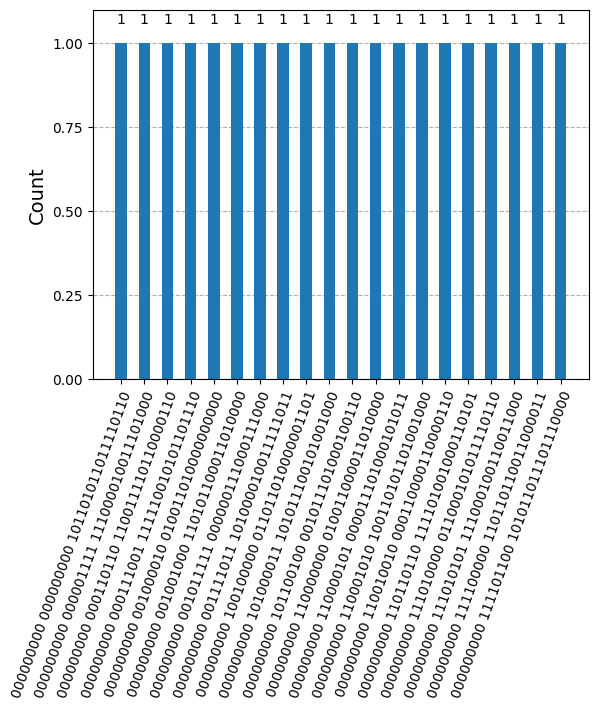

['000000000', '010100011', '000101100011100101']
[[0, 0, 0], [1, 0, 1], [1, 0, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1]]


TypeError: cannot unpack non-iterable int object

In [ ]:

sim_qubits = SurfaceCode(4,0)

#sim_qubits.circuit.measure(sim_qubits.x_stabilizer_qubits[0],sim_qubits.x_syndrome_bits[0])



#sim_qubits.add_x_stabilizer_measurement(0,sim_qubits.x_generators[0])
#sim_qubits.add_z_stabilizer_measurement(0,sim_qubits.z_generators[0])
#sim_qubits.initalize_state("z",1,0)
x_e=2
for i in range(0,3):
    #if i==1:
     #   sim_qubits.circuit.x(sim_qubits.data_qubits[x_e])
    sim_qubits.add_cycle_stabilizers()
    x_flags, z_flags, error_exists, raw_result = sim_qubits.error_detection(None, None, simulator = True)

    if error_exists:
        sim_qubits.decoder_minimum_weight_perfect_matching(x_flags, z_flags)
        raw_result = sim_qubits.correct_error(None, None, simulator = True)
#print("X"+ str(sim_qubits.old_x_syndrome))
#TODO Add error

sim_qubits.circuit.draw(output="mpl")
#run first round of stabilizers

#induce error
stats = raw_result.get_counts()
c = list(stats.items())[995:1015]
print(len(list(stats.items())))
display(plot_histogram(dict(c)))
max = 0
for s in stats:
    if max<stats[s]:
        max = stats[s]
        syn_string = s
syn = syn_string.split()
physical_qubit_lattice = []
print(syn)
x_syndrome = list(map(int, list(syn[1])))
z_syndrome = list(map(int, list(syn[0])))
for i in range(0,len(syn[2]),sim_qubits.n):
    row = []
    for j in range(0,sim_qubits.n):
        row.append(int(syn[2][i+j]))
    physical_qubit_lattice.append(row)
print(physical_qubit_lattice)
#if error detected, record in pauli frame
b1, b2= sim_qubits.get_logical_qubits("z", physical_qubit_lattice)
#repeat for several rounds
print("Bit 1: "+str(b1))
print("Bit 2: "+str(b2))


# Testing Zone

Messy area where I test for expected behavior and debug simulation. Left in for

In [ ]:
#Test Get Logical Qubits
physical_qubits0 = [[0,0,0],[0,0,0],[0,0,0],[0,1,1],[0,0,0],[0,0,0]]
test = SurfaceCode(4,0)
b1,b2 = test.get_logical_qubits("z", physical_qubits0)
print("Logical qubits are "+str(b1)+" "+str(b2))

Logical qubits are 0 0


In [ ]:
#Test lattice construction
test = SurfaceCode(4,6)
#Build Lattice
n = 2
lattice= test.construct_lattice(n)
print(2*(n*(n+1))+1)
expected1 = [[0, 1], [2, 3], [4, 5], [6, 7]]
if lattice != expected1:
  print("Mistake! You fool.")
  print("Expected: ")
  print(expected1)
  print("Generated: ")
  print(lattice)

n = 3
lattice= test.construct_lattice(n)
print(2*(n*(n+1))+1)
expected2 = [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11], [12, 13, 14], [15, 16, 17]]
if lattice != expected2:
  print("Mistake! You fool.")
  print("Expected: ")
  print(expected2)
  print("Generated: ")
  print(lattice)

13
25


In [ ]:
#Check x and z generator creation
print(test.create_x_generators(lattice,3))

[[16, 0, 1, 4], [17, 1, 2, 5], [15, 2, 0, 3], [4, 6, 7, 10], [5, 7, 8, 11], [3, 8, 6, 9], [10, 12, 13, 16], [11, 13, 14, 17], [9, 14, 12, 15]]


In [ ]:
print(test.create_z_generators(expected2,3))

[[0, 4, 3, 6], [1, 5, 4, 7], [2, 3, 5, 8], [6, 10, 9, 12], [7, 11, 10, 13], [8, 9, 11, 14], [12, 16, 15, 0], [13, 17, 16, 1], [14, 15, 17, 2]]


Stabilizer Tests

In [ ]:
test = SurfaceCode(4,6)
#test.circuit.draw(output="mpl")

In [ ]:
test.add_x_stabilizer_measurement(1,test.x_generators[1])

In [ ]:
#test.circuit.draw(output="mpl")

In [ ]:
test = SurfaceCode(4,6)
del test

In [ ]:
#test.circuit.draw(output="mpl")
#test.add_z_stabilizer_measurement(1,test.z_generators[1])
#test.circuit.draw(output="mpl")

In [ ]:
test = SurfaceCode(4,6)

In [ ]:
#Test registers keep values after circuit cleared - failed so just going to rerun full circuit and do not reset it unless want to start over
test.circuit.x(test.data_qubits[3])
test.circuit.h(test.data_qubits[2])
test.circuit.z(test.data_qubits[2])
test.circuit.h(test.data_qubits[2])
test.circuit.measure(3, test.x_syndrome_bits[2])
test.circuit.measure(2, test.x_syndrome_bits[3])

result = AerSimulator().run(test.circuit).result()

In [ ]:
print(result.get_counts())

{'000000000 000001100 000000000000000000': 1024}


In [ ]:

#test.circuit = QuantumCircuit(test.data_qubits, test.x_stabilizer_qubits, test.z_stabilizer_qubits, test.classical_data_bits, test.x_syndrome_bits, test.z_syndrome_bits)
test.circuit.measure(0, test.x_syndrome_bits[5])
result = AerSimulator().run(test.circuit).result()

In [ ]:
print(result.get_counts())

{'000000000 000001100 000000000000000000': 1024}


In [ ]:
def add_x_stabilizer_measurement(self, stabilizer_index, stabilizer):
    '''Add a specified stabilizer to the surface circuit'''
    test.circuit.h(test.x_stabilizer_qubits[stabilizer_index])
    for q in stabilizer:
      test.circuit.cx(test.x_stabilizer_qubits[stabilizer_index], test.data_qubits[q])

    test.circuit.h(test.x_stabilizer_qubits[stabilizer_index])
    test.circuit.measure(test.x_stabilizer_qubits[stabilizer_index], test.x_syndrome_bits[stabilizer_index])
    test.circuit.barrier()

In [ ]:
test = SurfaceCode(4,6)
#test.error_detection(None, None, simulator = True)
#test.circuit.h(test.data_qubits[0])
#test.circuit.x(test.data_qubits[0])
#test.add_z_stabilizer_measurement(0, test.z_generators[0])
#test.circuit.x(test.z_syndrome_bits[0])
'''test.circuit.x(test.data_qubits[0])
test.circuit.h(test.x_stabilizer_qubits[0])
print(test.x_generators[0])
gen = test.x_generators[0]
test.circuit.cx(test.data_qubits[gen[0]],test.x_stabilizer_qubits[0])
test.circuit.h(test.x_stabilizer_qubits[0])
test.add_x_stabilizer_measurement(1,test.x_generators[1])
for i in range(0,4):
  test.circuit.measure(test.z_stabilizer_qubits[i], test.z_syndrome_bits[i])
  test.circuit.measure(test.x_stabilizer_qubits[i], test.x_syndrome_bits[i])

print(test.z_generators[0])
#test.circuit.x(test.data_qubits[0])
#test.circuit.z(test.data_qubits[2])
#test.add_cycle_stabilizers()
#test.circuit.measure(test.x_stabilizer_qubits, test.x_syndrome_bits)
test.circuit.measure(test.data_qubits,test.classical_data_bits)
test.circuit.draw(output="mpl")'''


'test.circuit.x(test.data_qubits[0])\ntest.circuit.h(test.x_stabilizer_qubits[0])\nprint(test.x_generators[0])\ngen = test.x_generators[0]\ntest.circuit.cx(test.data_qubits[gen[0]],test.x_stabilizer_qubits[0])\ntest.circuit.h(test.x_stabilizer_qubits[0])\ntest.add_x_stabilizer_measurement(1,test.x_generators[1])\nfor i in range(0,4):\n  test.circuit.measure(test.z_stabilizer_qubits[i], test.z_syndrome_bits[i])\n  test.circuit.measure(test.x_stabilizer_qubits[i], test.x_syndrome_bits[i])\n\nprint(test.z_generators[0])\n#test.circuit.x(test.data_qubits[0])\n#test.circuit.z(test.data_qubits[2])\n#test.add_cycle_stabilizers()\n#test.circuit.measure(test.x_stabilizer_qubits, test.x_syndrome_bits)\ntest.circuit.measure(test.data_qubits,test.classical_data_bits)\ntest.circuit.draw(output="mpl")'

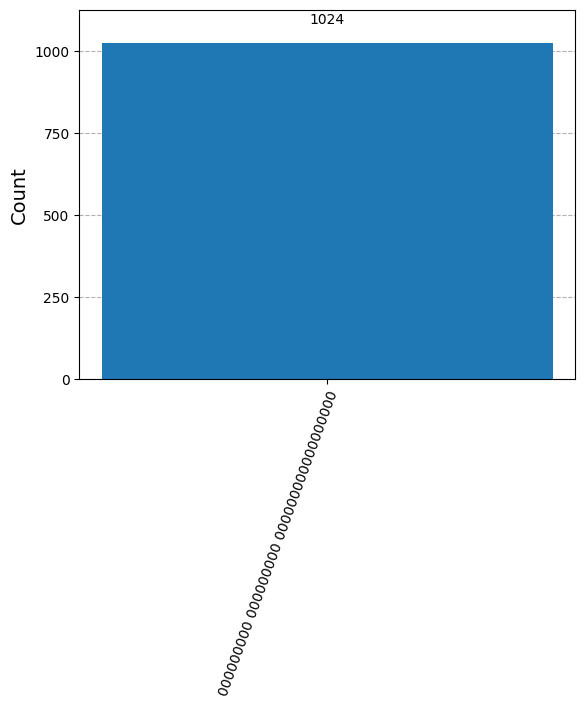

In [ ]:

x, z, error, result = test.error_detection(None, None, True)
c = list(result.get_counts().items())[:10]
display(plot_histogram(dict(c)))
if error:
  print(x)
  print(z)

In [ ]:
#Test DisjointSet
v = [0,1,4,5,7,8]
edgesComplete = []
for i in v:
    for j in v:
        if i != j:
            edgesComplete.append([i,j])

dj = DisjointSet(v)
print(" ")
print("Test 1: No Repeat Union")
print(" ")
#Union
print(dj.parent)
print(dj.paths)
print(dj.rank)
dj.union(0,1,[0,1])
print(" ")
#Check that same edge can't be added twice
dj.union(0,1,[0,1])
print(dj.parent)
print(dj.paths)
print(dj.rank)

print(" ")
print("Test 2: Multi Union")
print(" ")

print(dj.parent)
print(dj.paths)
print(dj.rank)
dj.union(0,1,{"v1":0,"v2":1})
print(" ")
#Check that same edge can't be added twice
dj.union(7,5,[7,5])
print(" ")
dj.union(4,8,[4,8])
print(" ")

print(dj.parent)
print(dj.paths)
print(dj.rank)
print(" ")
dj.union(1,4,[1,4])
print(" ")
print(dj.parent)
print(dj.paths)
print(dj.rank)

print(dj.get_highest_rank_tree())

 
Test 1: No Repeat Union
 
{0: 0, 1: 1, 4: 4, 5: 5, 7: 7, 8: 8}
{0: [], 1: [], 4: [], 5: [], 7: [], 8: []}
{0: 0, 1: 0, 4: 0, 5: 0, 7: 0, 8: 0}
 
{0: 0, 1: 0, 4: 4, 5: 5, 7: 7, 8: 8}
{0: [[0, 1]], 1: [[0, 1]], 4: [], 5: [], 7: [], 8: []}
{0: 1, 1: 0, 4: 0, 5: 0, 7: 0, 8: 0}
 
Test 2: Multi Union
 
{0: 0, 1: 0, 4: 4, 5: 5, 7: 7, 8: 8}
{0: [[0, 1]], 1: [[0, 1]], 4: [], 5: [], 7: [], 8: []}
{0: 1, 1: 0, 4: 0, 5: 0, 7: 0, 8: 0}
 
 
 
{0: 0, 1: 0, 4: 4, 5: 7, 7: 7, 8: 4}
{0: [[0, 1]], 1: [[0, 1]], 4: [[4, 8]], 5: [[7, 5]], 7: [[7, 5]], 8: [[4, 8]]}
{0: 1, 1: 0, 4: 1, 5: 0, 7: 1, 8: 0}
 
 
{0: 0, 1: 0, 4: 0, 5: 7, 7: 7, 8: 4}
{0: [[0, 1], [4, 8], [1, 4]], 1: [[0, 1]], 4: [[4, 8], [1, 4]], 5: [[7, 5]], 7: [[7, 5]], 8: [[4, 8]]}
{0: 3, 1: 0, 4: 1, 5: 0, 7: 1, 8: 0}
[[0, 1], [4, 8], [1, 4]]


In [ ]:
# Test Tree
#Initalized successfully
test_tree = Tree(1)
print(test_tree.root)
print(test_tree.nodes)

#Test adding a single one
test_tree.add_to_path(1,2)
print(test_tree.nodes)

#Test multi add
test_tree.add_to_path(1,[3,4])
print(test_tree.nodes)

test_tree.add_to_path(2,5)
print(test_tree.nodes)

path, d = test_tree.get_path_to_root(5)
print(path)
print(d)

path, d = test_tree.get_path_to_root(3)
print(path)
print(d)


AttributeError: 'Tree' object has no attribute 'nodes'

In [ ]:
#Graph Tests
test_graph = Graph()
#Create a graph of stabilizers with errors on 1 and 10th qubit
for i in range(0,9):
  test_graph.add_vertex(i)



test_graph.add_edge(1,2,1,[1])
test_graph.add_edge(1,4,1,[4])
test_graph.add_edge(1,7,2,[4,10])

test_graph.add_edge(4,7,1,[10])
test_graph.add_edge(2,4,2,[1,4])
test_graph.add_edge(2,7,3,[1,4,10])

print(test_graph.vertexes)
print(test_graph.edges)

min_tree = test_graph.get_minimum_spanning_tree()
print(min_tree)




[0, 1, 2, 3, 4, 5, 6, 7, 8]
[{'v1': 1, 'v2': 2, 'weight': 1, 'data_qubit_path': [1]}, {'v1': 1, 'v2': 4, 'weight': 1, 'data_qubit_path': [4]}, {'v1': 1, 'v2': 7, 'weight': 2, 'data_qubit_path': [4, 10]}, {'v1': 4, 'v2': 7, 'weight': 1, 'data_qubit_path': [10]}, {'v1': 2, 'v2': 4, 'weight': 2, 'data_qubit_path': [1, 4]}, {'v1': 2, 'v2': 7, 'weight': 3, 'data_qubit_path': [1, 4, 10]}]
{0: 0, 1: 2, 2: 1, 3: 0, 4: 2, 5: 0, 6: 0, 7: 1, 8: 0}
{2: 1, 7: 1, 1: 2, 4: 2}
2
[]
7
[2, 1]
1
[2, 1, 7, 4]
4
[2, 1, 7, 4]
[{'v1': 1, 'v2': 2, 'weight': 1, 'data_qubit_path': [1]}, {'v1': 4, 'v2': 7, 'weight': 1, 'data_qubit_path': [10]}]


In [ ]:
#Test Node
test_node = Node(None, "p")
test_child1 =Node(test_node, "c1")
test_child2 =Node(test_node, "c2")
test_child3 =Node(test_node, "c3")

children = [test_child2,test_child3]

test_node.add_child(test_child1)
print(test_node.children)

test_node.add_children(children)
print(test_node.children)


[<__main__.Node object at 0x14a5ee0d0>, <__main__.Node object at 0x14a5edf90>, <__main__.Node object at 0x13fe51480>]


In [ ]:
#Test Update Pauli Frame
test_code = SurfaceCode(4, 1)
print(test_code.x_pauli_frame)
print(test_code.z_pauli_frame)
test_code.update_pauli_frame([0,2],[1,5])
print("After update")
print(test_code.x_pauli_frame)
print(test_code.z_pauli_frame)
test_code.update_pauli_frame([0,2],[1,5])
print("After second update")
print(test_code.x_pauli_frame)
print(test_code.z_pauli_frame)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
After update
[1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[-1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
After second update
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
#Test Apply Pauli Frame
test_code = SurfaceCode(4, 1)
print(test_code.x_pauli_frame)
print(test_code.z_pauli_frame)
test_code.update_pauli_frame([0,2],[1,5])
test_code.apply_pauli_frame()
test_code.circuit.draw(output="mpl")


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
test_code =SurfaceCode(4,0)
print(test_code.lattice)
print(test_code.lattice[4][2])

[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11], [12, 13, 14], [15, 16, 17]]
14


In [ ]:
#test x and z generators

for i in range(0,len(test_code.x_generators)):
    print("For generators "+str(i))
    print("X Generators "+str(test_code.x_generators[i]))
    print("Z Generators "+str(test_code.z_generators[i]))

For generators 0
X Generators [0, 1, 16, 4]
Z Generators [0, 6, 3, 4]
For generators 1
X Generators [1, 2, 17, 5]
Z Generators [1, 7, 4, 5]
For generators 2
X Generators [2, 0, 15, 3]
Z Generators [2, 8, 5, 3]
For generators 3
X Generators [6, 7, 4, 10]
Z Generators [6, 12, 9, 10]
For generators 4
X Generators [7, 8, 5, 11]
Z Generators [7, 13, 10, 11]
For generators 5
X Generators [8, 6, 3, 9]
Z Generators [8, 14, 11, 9]
For generators 6
X Generators [12, 13, 10, 16]
Z Generators [12, 0, 15, 16]
For generators 7
X Generators [13, 14, 11, 17]
Z Generators [13, 1, 16, 17]
For generators 8
X Generators [14, 12, 9, 15]
Z Generators [14, 2, 17, 15]


In [ ]:
#Test data qubits transversed by path
test_code = SurfaceCode(4,0)
print(test_code.z_generators)
path = [3,5]
#X
datax = test_code.data_qubits_transversed_by_path("x", path)
print("X Data qubits transversed by path "+str(path)+" are: "+str(datax))
#Z
dataz = test_code.data_qubits_transversed_by_path("z", path)
print("Z Data qubits transversed by path "+str(path)+" are: "+str(dataz))

[[0, 6, 3, 4], [1, 7, 4, 5], [2, 8, 5, 3], [6, 12, 9, 10], [7, 13, 10, 11], [8, 14, 11, 9], [12, 0, 15, 16], [13, 1, 16, 17], [14, 2, 17, 15]]
3 5 has overlap [6]
X Data qubits transversed by path [3, 5] are: [6]
Z Data qubits transversed by path [3, 5] are: [9]


In [ ]:
test.circuit.draw(output="mpl")

In [ ]:
#Test Flag Graph

#Dummy data
#One type of error each x on qubit 1 abd z on qubit 6
x_flags = [1,1,0,0,0,0,1,0,1]
z_flags = [1,0,0,0,0,0,1,0,0]

test_code = SurfaceCode(4,0)
xflag_graph, xd = test_code.flag_graphs(x_flags)
zflag_graph, zd =test_code.flag_graphs(z_flags)

print("X Generators")
print(test_code.x_generators)
print("Z Generators")
print(test_code.z_generators)
#One type of error each x on qubit 1 abd z on qubit 6 xz on qubit 12

X Flag Graph
[{'v1': 1, 'v2': 0, 'weight': 1, 'data_qubit_path': [0, 1]}, {'v1': 6, 'v2': 0, 'weight': 1, 'data_qubit_path': [0, 6]}, {'v1': 6, 'v2': 1, 'weight': 2, 'data_qubit_path': [1, 0, 6]}, {'v1': 8, 'v2': 0, 'weight': 2, 'data_qubit_path': [0, 2, 8]}, {'v1': 8, 'v2': 1, 'weight': 2, 'data_qubit_path': [1, 2, 8]}, {'v1': 8, 'v2': 6, 'weight': 1, 'data_qubit_path': [6, 8]}]
Z Flag Graph
[{'v1': 6, 'v2': 0, 'weight': 1, 'data_qubit_path': [0, 6]}]


In [ ]:
x_min_span = xflag_graph.get_minimum_spanning_tree()
z_min_span = zflag_graph.get_minimum_spanning_tree()
'''print("X Flag Graph")
print(x_min_span)
print("Z Flag Graph")       
print(z_min_span)'''

x_data_qubits = []
z_data_qubits = []
for e in x_min_span:
    x_data_qubits = x_data_qubits+test_code.data_qubits_transversed_by_path("x", e["data_qubit_path"])
for e in z_min_span:
    z_data_qubits = z_data_qubits+test_code.data_qubits_transversed_by_path("z", e["data_qubit_path"])


'''print("X Data Qubits")
print(x_data_qubits)
print("Z Data Qubits")
print(z_data_qubits)'''

test_code.update_pauli_frame(x_data_qubits, z_data_qubits)
test_code.apply_pauli_frame()


{0: 2, 1: 1, 6: 2, 8: 1}
{1: 1, 8: 1, 0: 2, 6: 2}
1
[]
8
[1, 0]
{0: 1, 6: 1}
{0: 1, 6: 1}
0
[]
X Flag Graph
[{'v1': 1, 'v2': 0, 'weight': 1, 'data_qubit_path': [0, 1]}, {'v1': 8, 'v2': 6, 'weight': 1, 'data_qubit_path': [6, 8]}]
Z Flag Graph
[{'v1': 6, 'v2': 0, 'weight': 1, 'data_qubit_path': [0, 6]}]
0 1 has overlap [1]
6 8 has overlap [12]
0 6 has overlap [0]
X Data Qubits
[1, 12]
Z Data Qubits
[0]


# References

Resources used:
* https://arthurpesah.me/blog/2023-05-13-surface-code/
* https://errorcorrectionzoo.org/c/rotated_surface
* https://errorcorrectionzoo.org/c/stab_4_2_2
* https://github.com/quantumjim/qec_lectures/blob/main/lecture-1.ipynb
* https://www.youtube.com/watch?v=M25fBmF9XR0
* https://github.com/The-Singularity-Research/QISKit-Surface-Codes?tab=readme-ov-file

This last link is very reader friendly and straightforward.
* https://decodoku.blogspot.com/2016/03/8-toric-code-part-3.html

Original Paper
* https://arxiv.org/pdf/quant-ph/9811052

Really good paper on nitty gritty on measuring stabilizer qubits
* https://pure.tue.nl/ws/portalfiles/portal/318595789/1011230_-_Snijders_J.A.C._-_MSc_thesis_Thesis_-_MAP.pdf

Implementing a rotated surface code, as far as I understand it:

1. Initialize qubits
   - Define grid size for a rotated surface code of distance d.
     - This means the number of data qubits (physical non-ancilla qubits) is d^2.
     - 3x3 grid ==> 9 data qubits.

2. Create a lattice:
   - Let each qubit be a vertex in a d×d grid.
   - Assign a qubit to each of the vertices on the grid.

3. Initialize the logical qubit:
   - Apply a **logical \(X\)** and/or **logical \(Z\)** operator to encode the logical qubit (e.g., by applying a chain of qubits across rows and columns).
    - I'm not suuuuper clear on the nitty gritty of this part...but I imagine we can use the same circuits as the toric code paper? Should be fine as long as we keep track of boundary conditions

4. Apply stabilizer measurements (star and plaquette):
   - A star stabilizer acts on a qubit and its neighboring qubits (connected to a vertex).
   - A plaquette stabilizer acts on four qubits in a square arrangement.
   - Apply each stabilizer by measuring the state of neighboring qubits:
     - For each **plaquette stabilizer**:
       - Measure the parity of four qubits that form a square (e.g., top-left, top-right, bottom-left, bottom-right of a plaquette).
     - For each **star stabilizer**:
       - Measure the parity of four qubits connected to a vertex.

5. Syndrome measurement:
   - Measure the stabilizers (parity of qubits) to detect errors.
   - If the syndrome indicates an error (for example, a flipped bit), you can to correct the error by applying the appropriate gate
   - Store the syndrome outcome (e.g., which stabilizers detected an error)
   - Do we want to do this Pauli frame stuff? That would go here ish

6. Error correction (move this to later if we do PF):
   - If the syndrome indicates a flipped bit or phase, apply a correction based on the syndrome information

7. Iterate:
   - Repeat the process for each time step until the logical qubit is read out with high fidelity.

8. Logical qubit measurement:
   - PF corrections go here if we do that.
   - Once error correction is complete, measure the logical qubit to extract the result.

9. Return the result:
   - The final measurement outcome is the state of the logical qubit after the error correction process.

